In [1]:
import os
import time
import glob
import pandas as pd
import numpy  as np
import tables as tb

%matplotlib notebook
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm     as colormap

from mpl_toolkits               import mplot3d
from mpl_toolkits.mplot3d       import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

plt.rcParams["font.size"]      = 12
plt.rcParams["font.family"]    = "sans-serif"
plt.rcParams["font.monospace"] = "Computer Modern Sans Serif"

from invisible_cities.core.system_of_units import *
from invisible_cities.core.configure       import configure
from invisible_cities.core.configure       import all             as all_events

from invisible_cities.database import load_db

In [3]:
inputfilename = os.path.expandvars("$HOME/NEXT/DATA/processing/next100/beersheba/beersheba_8_0nubb.h5")
config = pd.read_hdf(inputfilename, "MC/configuration").set_index("param_key")

# Paolina

In [4]:
from invisible_cities.io.hits_io     import hits_from_df

from invisible_cities.types.ic_types import xy
from invisible_cities.evm            import event_model       as evm
from invisible_cities.reco           import paolina_functions as plf

from invisible_cities.types.ic_types          import         types_dict_tracks

def track_blob_info_creator_extractor(vox_size         : [float, float, float],
                                      strict_vox_size  : bool                 ,
                                      energy_threshold : float                ,
                                      min_voxels       : int                  ,
                                      blob_radius      : float                ,
                                      max_num_hits     : int):
    def create_extract_track_blob_info(hitc):
        df = pd.DataFrame(columns=list(types_dict_tracks.keys()))
        if len(hitc.hits) > max_num_hits:
            return df, hitc, True
        #track_hits is a new Hitcollection object that contains hits belonging to tracks, and hits that couldnt be corrected
        track_hitc = evm.HitCollection(hitc.event, hitc.time)
        out_of_map = np.any(np.isnan([h.Ep for h in hitc.hits]))
        if out_of_map:
            #add nan hits to track_hits, the track_id will be -1
            track_hitc.hits.extend  ([h for h in hitc.hits if np.isnan   (h.Ep)])
            hits_without_nan       = [h for h in hitc.hits if np.isfinite(h.Ep)]
            #create new Hitcollection object but keep the name hitc
            hitc      = evm.HitCollection(hitc.event, hitc.time)
            hitc.hits = hits_without_nan

        if len(hitc.hits) > 0:
            voxels           = plf.voxelize_hits(hitc.hits, vox_size, strict_vox_size, evm.HitEnergy.Ep)
            (    mod_voxels,
             dropped_voxels) = plf.drop_end_point_voxels(voxels, energy_threshold, min_voxels)
            tracks           = plf.make_track_graphs(mod_voxels)

            for v in dropped_voxels:
                track_hitc.hits.extend(v.hits)

            vox_size_x = voxels[0].size[0]
            vox_size_y = voxels[0].size[1]
            vox_size_z = voxels[0].size[2]
            del(voxels)
            #sort tracks in energy
            tracks     = sorted(tracks, key=plf.get_track_energy, reverse=True)

            track_hits = []
            for c, t in enumerate(tracks, 0):
                tID = c
                energy = plf.get_track_energy(t)
                length = plf.length(t)
                numb_of_hits   = len([h for vox in t.nodes() for h in vox.hits])
                numb_of_voxels = len(t.nodes())
                numb_of_tracks = len(tracks   )
                pos   = [h.pos for v in t.nodes() for h in v.hits]
                x, y, z = map(np.array, zip(*pos))
                r = np.sqrt(x**2 + y**2)

                e     = [h.Ep for v in t.nodes() for h in v.hits]
                ave_pos = np.average(pos, weights=e, axis=0)
                ave_r   = np.average(r  , weights=e, axis=0)
                extr1, extr2 = plf.find_extrema(t)
                extr1_pos = extr1.XYZ
                extr2_pos = extr2.XYZ

                blob_pos1, blob_pos2 = plf.blob_centres(t, blob_radius)

                e_blob1, e_blob2, hits_blob1, hits_blob2 = plf.blob_energies_and_hits(t, blob_radius)
                overlap = float(sum(h.Ep for h in set(hits_blob1).intersection(set(hits_blob2))))
                list_of_vars = [hitc.event, tID, energy, length, numb_of_voxels,
                                numb_of_hits, numb_of_tracks,
                                min(x), min(y), min(z), min(r), max(x), max(y), max(z), max(r),
                                *ave_pos, ave_r, *extr1_pos,
                                *extr2_pos, *blob_pos1, *blob_pos2,
                                e_blob1, e_blob2, overlap,
                                vox_size_x, vox_size_y, vox_size_z]

                df.loc[c] = list_of_vars

                for vox in t.nodes():
                    for hit in vox.hits:
                        hit.track_id = tID
                        track_hits.append(hit)

            #change dtype of columns to match type of variables
            df = df.apply(lambda x : x.astype(types_dict_tracks[x.name]))
            track_hitc.hits.extend(track_hits)
        return df, mod_voxels, track_hitc, out_of_map

    return create_extract_track_blob_info

In [5]:
Summary  = pd.read_hdf(inputfilename, "Summary/Events")
DECO     = pd.read_hdf(inputfilename, "DECO/Events")
MCHITS   = pd.read_hdf(inputfilename, "MC/hits")
eventMap = pd.read_hdf(inputfilename, "Run/eventMap")

In [6]:
# choose an event
event = eventMap.sample(1)
event = eventMap.loc[15:15]

deco   = DECO  [DECO  ["event"]    == event["evt_number"].values[0]].copy()
mchits = MCHITS[MCHITS["event_id"] == event["nexus_evt"] .values[0]].copy()

In [7]:
paolina_params = dict( vox_size         = [10 * mm, 10 * mm, 10 * mm]
                     , strict_vox_size  = False
                     , energy_threshold = 10 * keV
                     , min_voxels       = 3
                     , blob_radius      = 21 * mm
                     , max_num_hits     = 30000)

paolina_algorithm = track_blob_info_creator_extractor(**paolina_params)

# deco hits
# DECO = DECO.reindex(columns=CHITS.columns)
deco.loc[:, "time"] = 0
deco.loc[:, "Ec"]   = deco["E"]
deco.loc[:, "Ep"]   = deco["E"]
deco.loc[:, ("Q", "Xrms", "Yrms", "nsipm")] = np.nan

# Paolina
t0 = time.time()
hitc = hits_from_df(deco)[deco["event"].unique()[0]]
print("Hit collection:", time.time()-t0)

t0 = time.time()
df, voxels, track_hitc, out_of_map = paolina_algorithm(hitc)
print("Paolina:", time.time()-t0)

Hit collection: 1.9256808757781982
Paolina: 1.9126248359680176


In [8]:
# My reco
hits = pd.DataFrame()
hits["x"] = [voxel.X for voxel in voxels]
hits["y"] = [voxel.Y for voxel in voxels]
hits["z"] = [voxel.Z for voxel in voxels]
hits["E"] = [voxel.E for voxel in voxels]

# blob 1
b1 = hits.loc[hits["E"].idxmax()]
hits.loc[:, "R"] = ((hits["x"]-b1.x)**2+(hits["y"]-b1.y)**2+(hits["z"]-b1.z)**2)**0.5
b1_hits = hits[hits["R"]<=paolina_params["blob_radius"]]

In [9]:
# select track ids with length>0
df = df[df["length"]>0]
track_ids = df.trackID.values

voxels = [voxel for voxel in voxels if voxel.hits[0].track_id in track_ids]

In [10]:
# voxel_pos  = np.array([voxel.pos for voxel in voxels])
# voxel_ene  = np.array([voxel.E   for voxel in voxels])

# lower_corners = np.array([voxel.pos-voxel.size/2. for voxel in voxels])
# upper_corners = np.array([voxel.pos+voxel.size/2. for voxel in voxels])
# corners = np.concatenate((lower_corners, upper_corners))
# corners = np.unique(corners, axis=0)
# xbins, ybins, zbins = np.unique(corners[:, 0]), np.unique(corners[:, 1]), np.unique(corners[:, 2])

# hist, _ = np.histogramdd(voxel_pos, bins=[xbins, ybins, zbins], weights=voxel_ene)
# filled  = hist>0
# x, y, z = np.meshgrid(xbins, ybins, zbins, indexing="ij")

voxel_size = voxels[0].size
voxel_pos  = np.array([voxel.pos for voxel in voxels])
voxel_ene  = np.array([voxel.E   for voxel in voxels])

min_corner = np.min(voxel_pos, axis=0) - voxel_size/2.
max_corner = np.max(voxel_pos, axis=0) + voxel_size/2.

xbins = np.arange(min_corner[0], max_corner[0] + voxel_size[0], voxel_size[0])
ybins = np.arange(min_corner[1], max_corner[1] + voxel_size[0], voxel_size[1])
zbins = np.arange(min_corner[2], max_corner[2] + voxel_size[0], voxel_size[2])
x, y, z = np.meshgrid(xbins, ybins, zbins, indexing="ij")

hist, _ = np.histogramdd(voxel_pos, bins=[xbins, ybins, zbins], weights=voxel_ene)
filled  = hist>0

# color
norm   = colors  .Normalize(vmin=min(voxel_ene), vmax=max(voxel_ene), clip=True)
mapper = colormap.ScalarMappable(norm=norm, cmap=colormap.coolwarm)

col = hist.astype(object)
for i, j, k in np.argwhere(filled):
    col[i, j, k] = mapper.to_rgba(col[i, j, k])
col[~filled] = None

<IPython.core.display.Javascript object>


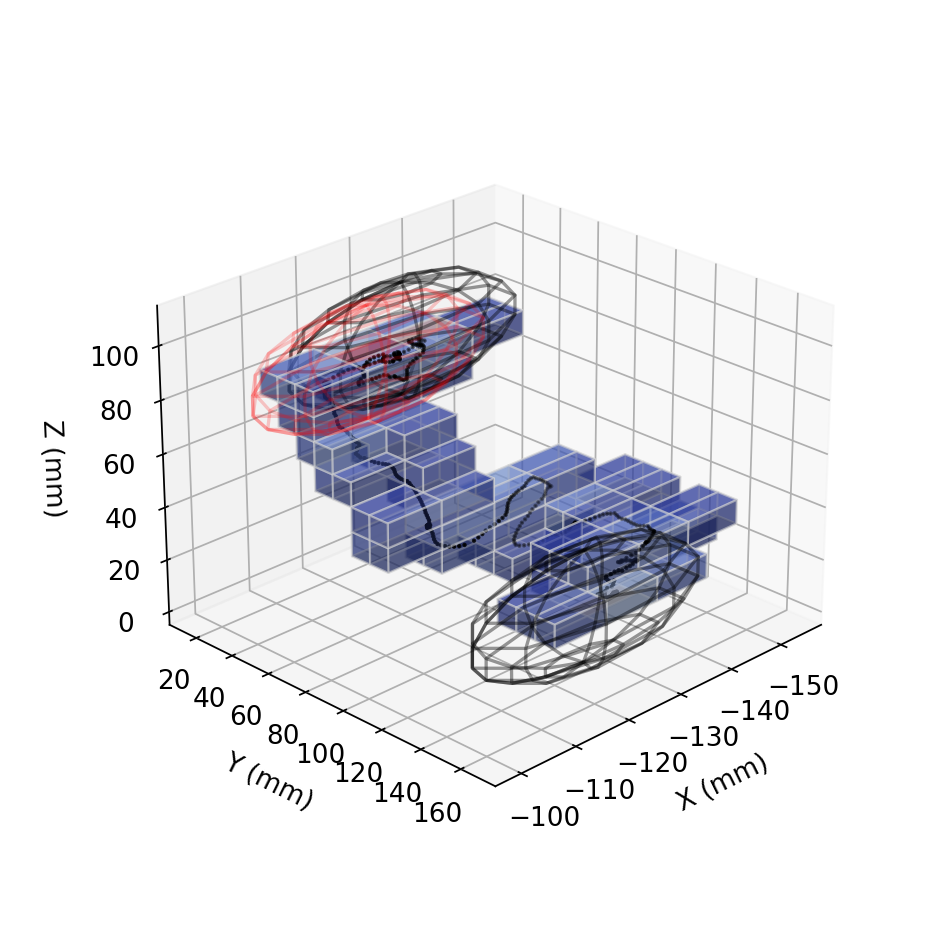

In [14]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

ax.voxels(x, y, z, filled, alpha=0.5, facecolors=col, edgecolor="lightgray")

# ax.scatter(voxel_pos[:, 0], voxel_pos[:, 1], voxel_pos[:, 2], facecolor=mapper.to_rgba(voxel_ene))

# mchits
ax.scatter(mchits["x"], mchits["y"], mchits["z"] + mchits["time"]/1e3, c="k", s=1)

# blobs
r = paolina_params["blob_radius"]
phi, theta = np.mgrid[0:2*np.pi:10j, 0:np.pi:10j]
xs = r*np.sin(theta)*np.cos(phi)
ys = r*np.sin(theta)*np.sin(phi)
zs = r*np.cos(theta)

# select track with maximum energy
t = df.loc[df["energy"].idxmax()]
b1_x, b1_y, b1_z = t.blob1_x, t.blob1_y, t.blob1_z
b2_x, b2_y, b2_z = t.blob2_x, t.blob2_y, t.blob2_z

ax.plot_wireframe(xs+b1_x, ys+b1_y, zs+b1_z, alpha=0.4, color="k")
ax.plot_wireframe(xs+b2_x, ys+b2_y, zs+b2_z, alpha=0.4, color="k")

# my blob
ax.plot_wireframe(xs+b1.x, ys+b1.y, zs+b1.z, alpha=0.2, color="r")

# plt.colorbar(mapper, ax=ax)

ax.set_xlabel("X (mm)", labelpad=8)
ax.set_ylabel("Y (mm)", labelpad=8)
ax.set_zlabel("Z (mm)", labelpad=8)

theta = 25
phi   = 45
ax.view_init(theta, phi);